In [1]:
# Set MPS memory limit before importing torch
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import StableDiffusionPipeline
import math
import glob
import random

# LoRA layer implementation
class LoRALayer(nn.Module):
    def __init__(self, in_dim, rank=8):
        super().__init__()
        self.in_dim = in_dim
        self.rank = rank

        # Initialize LoRA matrices
        self.lora_A = nn.Parameter(torch.zeros(in_dim, rank))
        self.lora_B = nn.Parameter(torch.zeros(rank, in_dim))
        self.scale = 0.1

        # Initialize weights
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        original_shape = x.shape
        if len(x.shape) > 2:
            x = x.view(-1, x.shape[-1])

        if x.shape[-1] != self.in_dim:
            raise ValueError(f"Input dimension {x.shape[-1]} doesn't match LoRA dimension {self.in_dim}")

        lora_contribution = (x @ self.lora_A) @ self.lora_B
        output = x + self.scale * lora_contribution
        return output.view(original_shape)

# Main I-LoRA implementation
class ILoRA:
    def __init__(self, model_id="CompVis/stable-diffusion-v1-4", rank=8):
        # Specific setup for M1 Mac
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        print(f"Using device: {self.device}")
    
        # Clear cache before loading models
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()
    
        # Load models in stages with memory clearing between loads
        print("Loading Stable Diffusion...")
        self.model = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float32,
            safety_checker=None
        ).to('cpu')  # Keep on CPU initially
    
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()
    
        print("Loading depth estimator...")
        self.depth_estimator = DPTForDepthEstimation.from_pretrained(
            "Intel/dpt-large",
            torch_dtype=torch.float32
        ).to('cpu')  # Keep on CPU initially
    
        print("Loading feature extractor...")
        self.feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
    
        self.rank = rank
    
        # Freeze parameters while still on CPU
        self._freeze_parameters()
    
        # Add LoRA layers while on CPU
        self._add_lora_layers()
    
        # Ensure all model parameters require gradients
        for param in self.model.unet.parameters():
            param.requires_grad = True
        for param in self.model.vae.parameters():
            param.requires_grad = True
        for param in self.model.text_encoder.parameters():
            param.requires_grad = True
    
        print("Moving models to device...")
        # Move models to device in stages
        try:
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()
            self.depth_estimator.to(self.device)
    
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()
            self.model.to(self.device)
    
        except RuntimeError as e:
            print("Memory error during model loading. Trying to free memory...")
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()
            raise e

    def _freeze_parameters(self):
        """Freeze all parameters in the base model"""
        # Freeze UNet parameters
        for param in self.model.unet.parameters():
            param.requires_grad = False

        # Freeze VAE parameters
        for param in self.model.vae.parameters():
            param.requires_grad = False

        # Freeze text encoder parameters
        for param in self.model.text_encoder.parameters():
            param.requires_grad = False

    def _add_lora_layers(self):
        self.lora_layers = []

        def create_attention_forward(original_forward, lora):
            def new_forward(self, x, *args, **kwargs):
                x = lora(x)
                return original_forward(self, x, *args, **kwargs)
            return new_forward
    
        def create_custom_forward(original_forward, lora, heads):
            def new_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
                batch_size, sequence_length, _ = hidden_states.shape
    
                query = self.to_q(hidden_states)
                query = lora(query)
    
                key = self.to_k(encoder_hidden_states if encoder_hidden_states is not None else hidden_states)
                value = self.to_v(encoder_hidden_states if encoder_hidden_states is not None else hidden_states)
    
                # Use head size from query projection dimensions
                head_size = query.shape[-1] // heads
    
                # Reshape attention patterns
                query = query.reshape(batch_size, -1, heads, head_size).transpose(1, 2)
                key = key.reshape(batch_size, -1, heads, head_size).transpose(1, 2)
                value = value.reshape(batch_size, -1, heads, head_size).transpose(1, 2)
    
                # Compute attention scores
                attention_scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(head_size)
    
                if attention_mask is not None:
                    attention_scores = attention_scores + attention_mask
    
                attention_probs = attention_scores.softmax(dim=-1)
                hidden_states = torch.matmul(attention_probs, value)
    
                # Reshape back
                hidden_states = hidden_states.transpose(1, 2).contiguous()
                hidden_states = hidden_states.reshape(batch_size, -1, heads * head_size)
    
                # Output projection
                hidden_states = self.to_out[0](hidden_states)
                hidden_states = self.to_out[1](hidden_states)
    
                return hidden_states
            return new_forward
    
        for name, module in self.model.unet.named_modules():
            if isinstance(module, torch.nn.MultiheadAttention):
                in_dim = module.embed_dim
                lora = LoRALayer(in_dim, self.rank).to(self.device)
                self.lora_layers.append(lora)
    
                module.forward = create_attention_forward(
                    module.forward,
                    lora
                ).__get__(module)
    
            elif "attn" in name and hasattr(module, 'to_q'):
                in_dim = module.to_q.out_features
                lora = LoRALayer(in_dim, self.rank).to(self.device)
    
                module.forward = create_custom_forward(
                    module.forward,
                    lora,
                    module.heads
                ).__get__(module)
    
                self.lora_layers.append(lora)

    def estimate_depth(self, images):
        """Estimate depth using DPT model"""
        if torch.is_tensor(images):
            images = [transforms.ToPILImage()(img.cpu()) for img in images]
    
        inputs = self.feature_extractor(images=images, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
    
        with torch.no_grad():
            outputs = self.depth_estimator(**inputs)
            predicted_depth = outputs.predicted_depth
    
            depth_min = predicted_depth.min()
            depth_max = predicted_depth.max()
            predicted_depth = (predicted_depth - depth_min) / (depth_max - depth_min)
    
        return predicted_depth

    def train_step(self, batch):
        try:
            # Clear MPS cache
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            images = batch['image'].to(self.device)
            print(f"Input image shape: {images.shape}")

            depths = self.estimate_depth(images)

            prompt = ["depth map"] * images.shape[0]

            outputs = self.model(
                prompt=prompt,
                image=images,
                num_inference_steps=10,  # Reduced for memory
                guidance_scale=7.5
            ).images

            # Convert PIL images to tensors
            outputs = torch.stack([transforms.ToTensor()(image) for image in outputs]).to(self.device)

            # Convert outputs to grayscale by averaging the RGB channels
            outputs = outputs.mean(dim=1, keepdim=True)

            # Resize depths to match outputs dimensions
            depths = depths.unsqueeze(1)  # Add channel dimension
            depths = F.interpolate(depths, size=outputs.shape[2:], mode='bilinear', align_corners=False)

            # Ensure depths tensor requires gradients
            depths.requires_grad = True

            loss = F.mse_loss(outputs, depths)

            # Ensure loss requires gradients
            assert loss.requires_grad, "Loss does not require gradients"

            return loss, outputs

        except RuntimeError as e:
            if "out of memory" in str(e):
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                raise e
            raise e
        
    def predict(self, image):
        with torch.no_grad():
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            output = self.model(
                prompt=["depth map"],
                image=image.unsqueeze(0),
                num_inference_steps=10,
                guidance_scale=7.5
            ).images[0]
            return output

    def verify_dimensions(self):
        """Verify that all dimensions match correctly"""
        print("\nVerifying dimensions:")
        for name, module in self.model.unet.named_modules():
            if hasattr(module, 'to_q'):
                print(f"\nModule: {name}")
                print(f"Query projection: {module.to_q.in_features} -> {module.to_q.out_features}")
                print(f"Number of heads: {module.heads}")
                print(f"Head size: {module.to_q.out_features // module.heads}")


2024-11-25 20:04:21.081075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset implementation

class LocalFaceDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(glob.glob(os.path.join(root_dir, ext)))
        print(f"Found {len(self.image_files)} images in {root_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return {'image': image}

# Set up dataset with memory-efficient parameters
transform = transforms.Compose([
    transforms.Resize(64),  # Reduced size for memory efficiency
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

# Create dataset
dataset = LocalFaceDataset(
    root_dir="faces",  # Your local directory with face images
    transform=transform
)

# Create subset of 250 samples as per paper
indices = random.sample(range(len(dataset)), min(100, len(dataset)))
dataset = Subset(dataset, indices)

# Use small batch size for memory efficiency
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
print(f"Created dataloader with {len(dataset)} samples")

# Training function
def train_ilora(model, dataloader, num_epochs=10):
    optimizer = torch.optim.AdamW(
        [p for layer in model.lora_layers for p in layer.parameters() if p.requires_grad],
        lr=1e-4
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            try:
                # Training step
                loss, predictions = model.train_step(batch)

                # Ensure loss requires gradients
                if not loss.requires_grad:
                    raise RuntimeError("Loss does not require gradients")

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                if batch_idx % 10 == 0:
                    print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

                # Clear memory
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("Memory error during training. Clearing cache and skipping batch...")
                    if torch.backends.mps.is_available():
                        torch.mps.empty_cache()
                    continue
                raise e

            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'unet_state_dict': model.model.unet.state_dict(),
                'vae_state_dict': model.model.vae.state_dict(),
                'text_encoder_state_dict': model.model.text_encoder.state_dict(),
                'depth_estimator_state_dict': model.depth_estimator.state_dict(),
                'lora_layers_state_dict': [layer.state_dict() for layer in model.lora_layers],
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'ilora_checkpoint_epoch_{epoch+1}.pt')

            # Visualize results for last batch
            if len(dataloader) > 0:
                sample_batch = next(iter(dataloader))
                sample_image = sample_batch['image'][0]
                estimated_depth = model.estimate_depth([sample_image])[0].squeeze().cpu().numpy()
                pred_depth = model.predict(sample_image)

                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(sample_image.permute(1, 2, 0))
                plt.title('Original Image')
                plt.subplot(132)
                plt.imshow(estimated_depth, cmap='magma')
                plt.title('Estimated Depth')
                plt.subplot(133)
                plt.imshow(pred_depth, cmap='magma')
                plt.title(f'Predicted Depth (Epoch {epoch+1})')
                plt.show()
                plt.close()

Found 202599 images in faces
Created dataloader with 100 samples


Initializing I-LoRA...
Using device: mps
Loading Stable Diffusion...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading depth estimator...


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/GPU/lib/python3.8/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Loading feature extractor...
Moving models to device...

Verifying dimensions:

Module: down_blocks.0.attentions.0.transformer_blocks.0.attn1
Query projection: 320 -> 320
Number of heads: 8
Head size: 40

Module: down_blocks.0.attentions.0.transformer_blocks.0.attn2
Query projection: 320 -> 320
Number of heads: 8
Head size: 40

Module: down_blocks.0.attentions.1.transformer_blocks.0.attn1
Query projection: 320 -> 320
Number of heads: 8
Head size: 40

Module: down_blocks.0.attentions.1.transformer_blocks.0.attn2
Query projection: 320 -> 320
Number of heads: 8
Head size: 40

Module: down_blocks.1.attentions.0.transformer_blocks.0.attn1
Query projection: 640 -> 640
Number of heads: 8
Head size: 80

Module: down_blocks.1.attentions.0.transformer_blocks.0.attn2
Query projection: 640 -> 640
Number of heads: 8
Head size: 80

Module: down_blocks.1.attentions.1.transformer_blocks.0.attn1
Query projection: 640 -> 640
Number of heads: 8
Head size: 80

Module: down_blocks.1.attentions.1.transforme

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 0, Loss: 0.1295
Epoch 1/10, Average Loss: 0.0013


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


  0%|          | 0/10 [00:00<?, ?it/s]

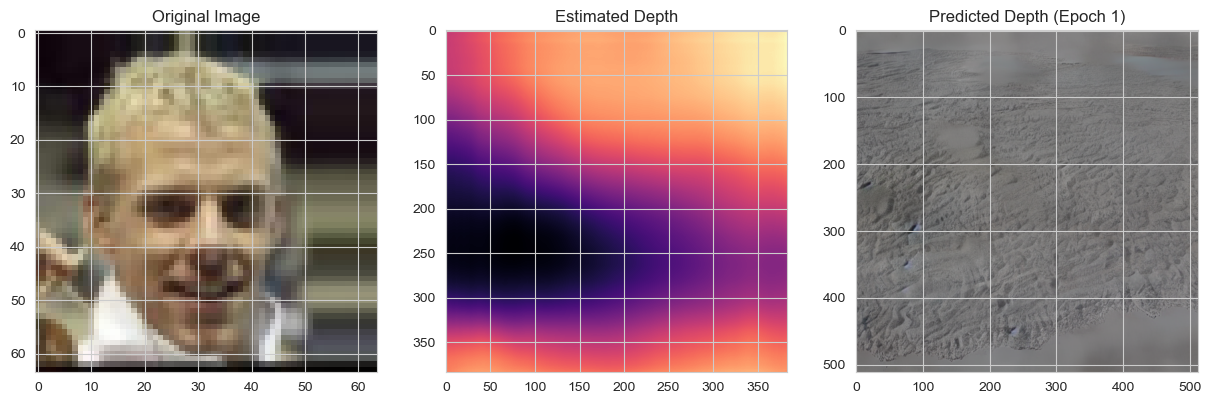

Input image shape: torch.Size([1, 3, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 0.0031


  0%|          | 0/10 [00:00<?, ?it/s]

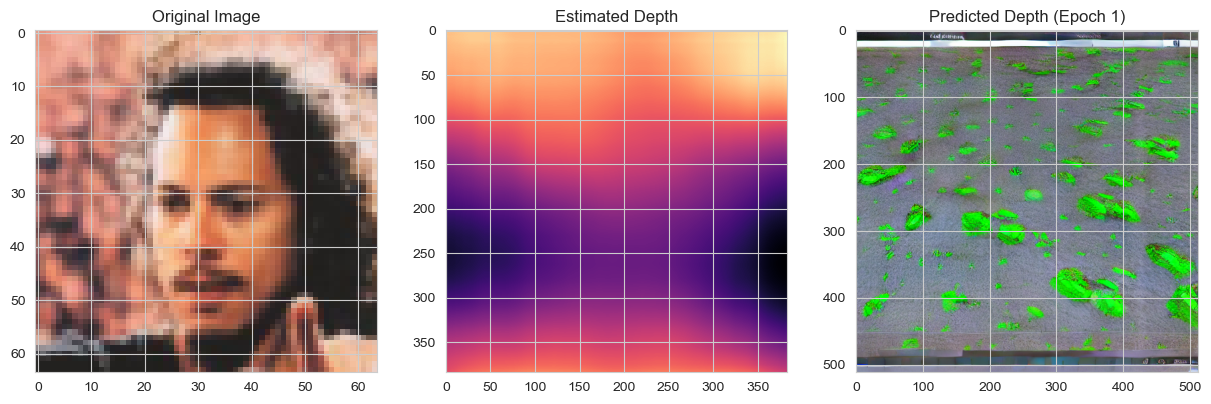

Input image shape: torch.Size([1, 3, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 0.0060


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
# Initialize and train
try:
    print("Initializing I-LoRA...")
    ilora = ILoRA()
    ilora.verify_dimensions()

    print("\nStarting training...")
    train_ilora(ilora, dataloader, num_epochs=10)

except RuntimeError as e:
    if "out of memory" in str(e):
        print("Memory error. Try reducing batch size or image size further.")
    raise e